In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


In [2]:
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/7XGBoost/train.csv"
response = requests.get(url)

if response.status_code == 200:
    data = StringIO(response.text)
    df = pd.read_csv(data)
    
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
  
    if 'RainTomorrow' in categorical_cols:
        categorical_cols.remove('RainTomorrow')

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
X = df.drop('RainTomorrow', axis=1)
y = LabelEncoder().fit_transform(df['RainTomorrow'].astype(str))

# Using ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),  # Apply transformations to numerical columns
        ('cat', categorical_transformer, categorical_cols)  # Apply transformations to categorical columns
    ])

# Apply preprocessing transformation
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Here we define X_train_processed and X_test_processed
X_train_processed = X_train
X_test_processed = X_test


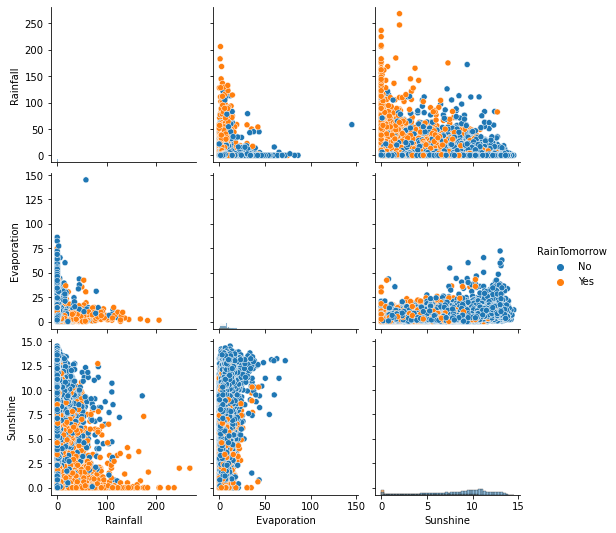

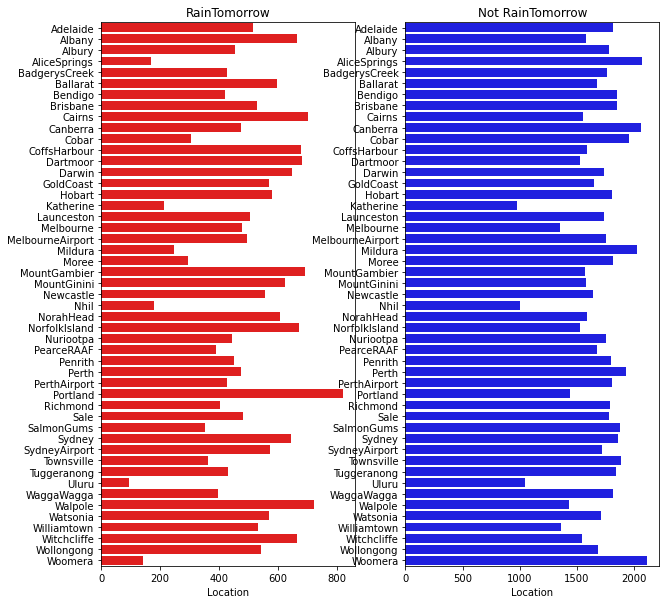

In [3]:
# Data visualization
# 1. Scatter plot visualization of three features with label combinations
sns.pairplot(data=df[['Rainfall', 'Evaporation', 'Sunshine', 'RainTomorrow']], diag_kind='hist', hue= 'RainTomorrow')
plt.show()

# 2. Bar plot visualization based on categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'RainTomorrow' in categorical_cols:
    categorical_cols.remove('RainTomorrow')

# Count the values of categorical features for labels "Yes" and "No"
tlog = {}
flog = {}
for i in categorical_cols:
    tlog[i] = df[df['RainTomorrow'] == 'Yes'][i].value_counts()
    flog[i] = df[df['RainTomorrow'] == 'No'][i].value_counts()

# Take 'Location' as an example and draw bar plots
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
sns.barplot(x = pd.DataFrame(tlog['Location']).sort_index()['Location'], y = pd.DataFrame(tlog['Location']).sort_index().index, color = "red")
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x = pd.DataFrame(flog['Location']).sort_index()['Location'], y = pd.DataFrame(flog['Location']).sort_index().index, color = "blue")
plt.show()


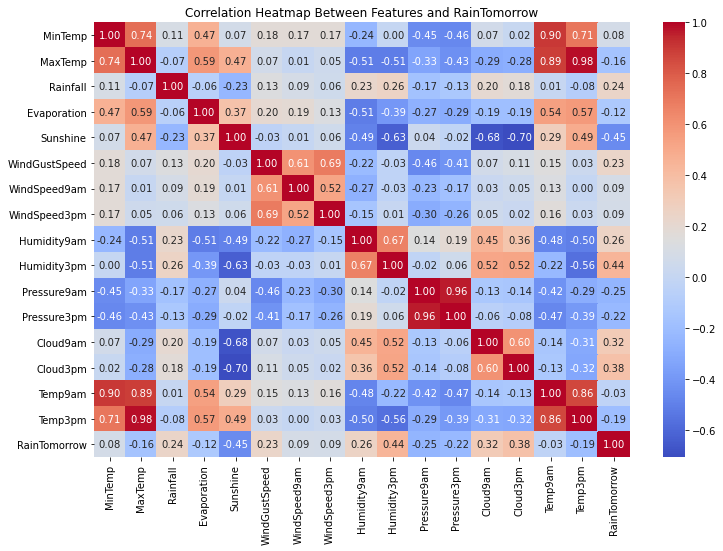

In [4]:
# 3.Calculate the correlation matrix among numerical features and the target variable 'RainTomorrow'
# Ensure 'RainTomorrow' is of a numerical type, if not, convert it
if df['RainTomorrow'].dtype == object:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

# Select numerical columns from df
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# If 'RainTomorrow' is not in the list of numerical features, add it
if 'RainTomorrow' not in numerical_features:
    numerical_features.append('RainTomorrow')

# Calculate the correlation matrix
corr_matrix = df[numerical_features].corr()

# Draw the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Between Features and RainTomorrow')
plt.show()


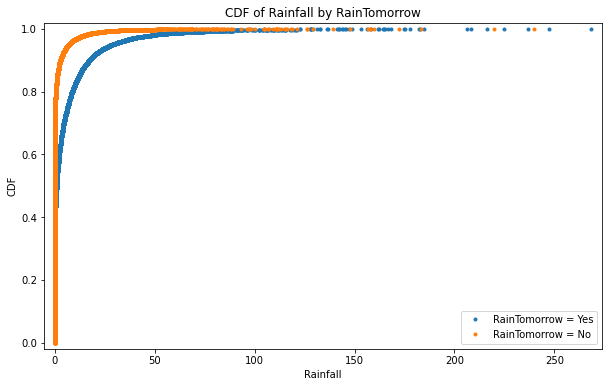

In [5]:
# 4. Filter the data for 'RainTomorrow' equals 'Yes' and 'No'
rain_yes = df[df['RainTomorrow'] == 1]['Rainfall'].dropna()
rain_no = df[df['RainTomorrow'] == 0]['Rainfall'].dropna()

# Function to calculate the Cumulative Distribution Function (CDF)
def calc_cdf(data):
    n = len(data)
    x = np.sort(data)  # sort data in ascending order
    y = np.arange(1, n+1) / n  # calculate the cumulative percentage
    return x, y

x_yes, y_yes = calc_cdf(rain_yes)
x_no, y_no = calc_cdf(rain_no)

# Plotting the CDF for rainfall where 'RainTomorrow' is 'Yes' and 'No'
plt.figure(figsize=(10, 6))
plt.plot(x_yes, y_yes, label='RainTomorrow = Yes', marker='.', linestyle='none')
plt.plot(x_no, y_no, label='RainTomorrow = No', marker='.', linestyle='none')
plt.legend()
plt.xlabel('Rainfall')
plt.ylabel('CDF')
plt.title('CDF of Rainfall by RainTomorrow')
plt.margins(0.02)  # Ensures a bit of margin on the sides of the plot
plt.show()


Training Accuracy: 0.8881204946375197
Test Accuracy: 0.8621595011486708
time： 3.5710060596466064 seconds


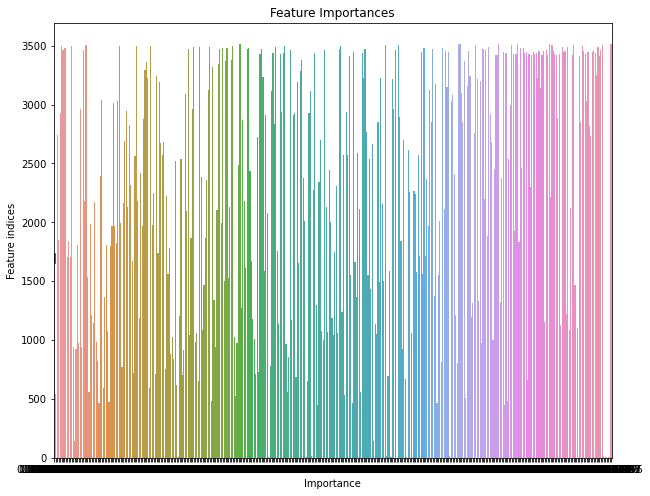

In [6]:
import time

start_time = time.time()
# Train the XGBoost model and adjust model parameters
model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    n_estimators=200,  # Increase the number of trees
    max_depth=8,       # Increase the depth of trees
    learning_rate=0.1  # Adjust the learning rate
)
model.fit(X_train_processed, y_train)  # Ensure using preprocessed data

# Predictions
predictions_train = model.predict(X_train_processed)
predictions_test = model.predict(X_test_processed)

# Evaluation
print('Training Accuracy:', metrics.accuracy_score(y_train, predictions_train))
print('Test Accuracy:', metrics.accuracy_score(y_test, predictions_test))
end_time = time.time()
print("time：", end_time - start_time, "seconds")
# Feature importance visualization
plt.figure(figsize=(10, 8))
sns.barplot(y=np.arange(len(model.feature_importances_)), x=model.feature_importances_)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature indices')
plt.show()


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)

# precision
precision_train = precision_score(y_train, predictions_train, average='binary')
precision_test = precision_score(y_test, predictions_test, average='binary')

# recall
recall_train = recall_score(y_train, predictions_train, average='binary')
recall_test = recall_score(y_test, predictions_test, average='binary')

# F1 score
f1_train = f1_score(y_train, predictions_train, average='binary')
f1_test = f1_score(y_test, predictions_test, average='binary')

print("Training Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


Training Metrics:
Accuracy: 0.8881204946375197
Precision: 0.8451441686988954
Recall: 0.6146903855182847
F1 Score: 0.7117272205611429

Test Metrics:
Accuracy: 0.8621595011486708
Precision: 0.7623762376237624
Recall: 0.5419065898912349
F1 Score: 0.6335078534031414
